In [0]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale



import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

import math

In [2]:
!rm TorchExperts.py
!wget https://raw.githubusercontent.com/andriygav/EMprior/master/code/TorchExperts.py

rm: cannot remove 'TorchExperts.py': No such file or directory
--2019-10-21 13:59:41--  https://raw.githubusercontent.com/andriygav/EMprior/master/code/TorchExperts.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12978 (13K) [text/plain]
Saving to: ‘TorchExperts.py’

TorchExperts.py     100%[===================>]  12.67K  --.-KB/s    in 0.008s  

2019-10-21 13:59:41 (1.46 MB/s) - ‘TorchExperts.py’ saved [12978/12978]



In [0]:
from tqdm import tqdm as tqdm

In [0]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

plt.rcParams["font.family"] = 'DejaVu Serif'

plt.rcParams['text.usetex'] = False

plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [0]:
from TorchExperts import EachModelLinear, HyperModelNN, MixtureExpert, RegularizeModel

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# All mixture of expert model

# Experiment

In [0]:
np.random.seed(0)
N = 200
n = 3
r1 = 0.5
r2 = 1.5
phi = np.linspace(0, 2*np.pi, N)

x0 = 0
y0 = 0

# x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0])
x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0, 4*(np.random.rand(200)-0.5) + x0])
x += 0.05*np.random.randn(x.shape[0])
# y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0])
y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0, 4*(np.random.rand(200)-0.5) + y0])
y += 0.05*np.random.randn(y.shape[0])



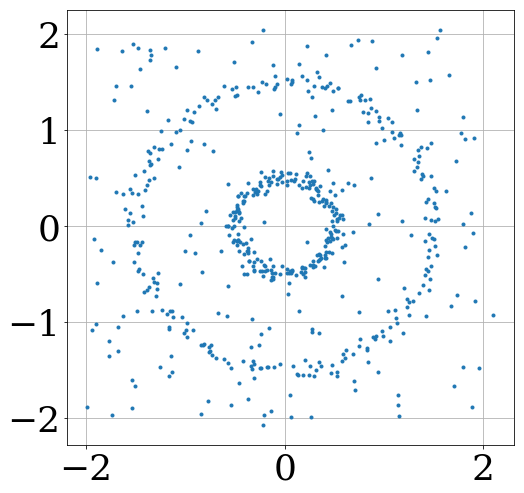

In [8]:
plt.plot(x, y, '.')

plt.grid()

plt.show()

In [0]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

In [10]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([600, 3]), torch.Size([600, 1]))

In [0]:
K = 2
LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]


LoM = []
for k in range(K):
#     LoM.append(EachModelLinear(input_dim = n, device = device))
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k], regul = True))
#       LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], regul = False))

# K += 1
# LoM.append(RegularizeModel(ListOfModels = LoM))

HypPar = {'beta': 1, 'alpha': 1}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=500)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)
# model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [], device = device)





In [141]:
%%time
model.fit(X_tr, Y_tr, 5, progress = tqdm)

100%|██████████| 5/5 [00:21<00:00,  4.24s/it]

CPU times: user 20.4 s, sys: 494 ms, total: 20.9 s
Wall time: 21.2 s


In [142]:
print(model.ListOfModels[0].A)

print(model.ListOfModels[1].A)

tensor([0.0035, 0.0011, 0.0017])
tensor([0.0003, 0.0002, 0.0011])


In [143]:
print(model.ListOfModels[0].B)

print(model.ListOfModels[1].B)

tensor([[ 3.3186e-03, -1.7372e-05,  4.4186e-05],
        [-1.7372e-05,  1.1378e-03,  9.4095e-06],
        [ 4.4186e-05,  9.4095e-06,  1.3986e-03]])
tensor([[ 2.7010e-04, -1.3473e-06, -1.2410e-06],
        [-1.3473e-06,  2.2307e-04, -4.8767e-07],
        [-1.2410e-06, -4.8767e-07,  8.5215e-04]])


In [144]:
print(model.ListOfModels[0].w_0)

print(model.ListOfModels[1].w_0)

tensor([[-0.3026],
        [-0.0992],
        [ 0.4096]])
tensor([[-1.0011e-01],
        [-5.1144e-04],
        [ 2.8365e+00]])


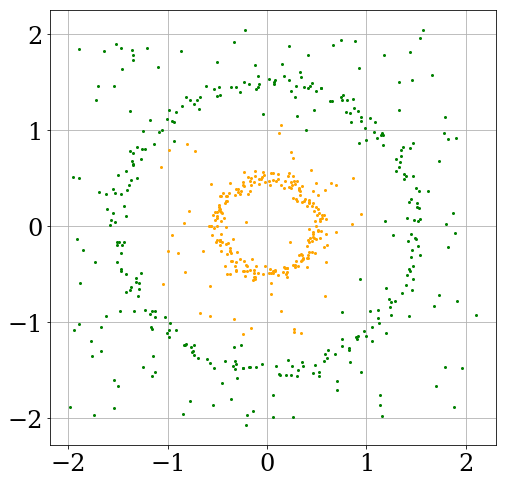

In [145]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
    
plt.grid()
plt.show()

In [146]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[-3.0329508e-01, -9.9292040e-02,  4.0964165e-01],
       [-1.0005117e-01, -4.8938917e-04,  2.8365395e+00]], dtype=float32)

In [147]:
CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = 0.5*param[:2]
    r = (param[2] + x0**2 + y0**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

array([[-1.5164754e-01, -4.9646020e-02,  6.5962362e-01],
       [-5.0025586e-02, -2.4469459e-04,  1.6849457e+00]], dtype=float32)

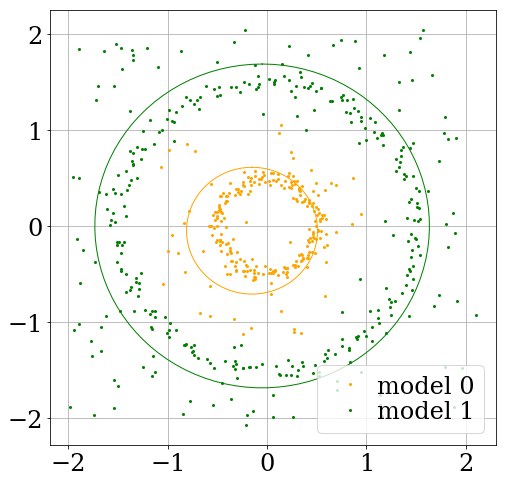

In [148]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in range(len(model.ListOfModels)):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')

# plt.savefig('results/full_infomative.pdf', )

plt.show()